# 차트 데이터 

In [1]:
from dbQuery import dbQuery, dfFilter, dfPlot

# 속성 추출
1. 차트 진입후 5위 이내까지 진입한 일수
2. 해당 곡 아티스트의 다른 곡이 차트에 진입한 일수
3. 차트 진입 후 5위 이내까지 일간 랭킹 상승 평균치
4. 네이버 트렌드와 음원차트의 상관계수
5. and more...

In [2]:
# 데이터베이스 내 음원의 수 = 학습시킬 레코드의 수

# 쿼리문 입력
query = """ SELECT DISTINCT title  FROM zuzak.genie; """

Chartdf = dbQuery(query)

# 쿼리결과 없으면
if Chartdf.empty:
    print('결과 데이터가 없습니다.')

# 쿼리 결과
else :
    print(Chartdf)
    all_song = Chartdf
    print('총 음원의 수 = '+str(len(Chartdf)))
    #데이터 정보 출력
    print(Chartdf.describe())


                                                 title
0                                         또하루(Feat.개코)
1                                                   소녀
2                                              걱정말아요그대
3                                                 어땠을까
4                                                   함께
5                                 DADDY(Feat.CLof2NE1)
6                                           혜화동(혹은쌍문동)
7                                            OOH-AHH하게
8                                                 나팔바지
9                                  19금유레카(Feat.Zion.T)
10                                        청춘(Feat.김창완)
11                                               우주를건너
12                                               또다시사랑
13                    BoysAndGirls(Feat.Babylon(베이빌론))
14                                               매일그대와
15                                        네게줄수있는건오직사랑뿐
16                                화이트(WHITE)(Feat.박재범)
17        

In [3]:
all_song.head()

,title
0,또하루(Feat.개코)
1,소녀
2,걱정말아요그대
3,어땠을까
4,함께


In [4]:
# 다른 노래 차트진입일
def chartInDays(title, artist, dbname):
    # 쿼리문 입력
    query = " SELECT * FROM zuzak."+dbname+" where title != \""+title+"\" and artist = \""+artist+"\" and YYMMDD<= (select YYMMDD from zuzak."+dbname+" where title = \""+title+"\" order by YYMMDD limit 1); "
    
    Chartdf = dbQuery(query)
    Chartdf = dfFilter(Chartdf)
    
    
    # 쿼리결과 없으면
    if Chartdf.empty:
        print('결과 데이터가 없습니다.')
        return 0
        
    # 쿼리 결과
    else :        
        return len(Chartdf)

In [5]:
# 다른 노래 차트진입일
chartInDays('좋니', '윤종신','mnet')

11

In [6]:
# 랭킹 상승 평균치
def rankIncreaseMean(title, dbname):
    # 쿼리문 입력
    query = """ SELECT * FROM zuzak."""+dbname+""" where title = \""""+title+"""\" and YYMMDD<=
    (select YYMMDD from zuzak."""+dbname+""" where title = \""""+title+"""\" and cast(ranking as unsigned) <=5 order by YYMMDD limit 1); """
    
    Chartdf = dbQuery(query)
    Chartdf = dfFilter(Chartdf)
    
    # 쿼리결과 없으면
    if Chartdf.empty:
        print('결과 데이터가 없습니다.')
        return 0
        
    # 쿼리 결과
    elif len(Chartdf) == 1 :
        sum = 100-Chartdf['ranking'][0]
        return sum
    
    else:
        sum = 0
        a = len(Chartdf)
        
        for i in range(1, a):
            num = (Chartdf['ranking'][i-1]) - (Chartdf['ranking'][i])
            sum = sum + num
        
        return sum/(a-1)
    

In [7]:
# 랭킹 상승 평균치
a = "I'mNotTheOnlyOne"
rankIncreaseMean(a,'genie')

결과 데이터가 없습니다.


0

In [8]:
# 5위 진입 전까지 일수
def rankInDays(title, dbname):
    # 쿼리문 입력
    query = """ SELECT * FROM zuzak."""+dbname+""" where title = \""""+title+"""\" and YYMMDD<=(SELECT YYMMDD FROM zuzak."""+dbname+""" where title = \""""+title+"""\" and cast(ranking as unsigned) <=5  order by YYMMDD limit 1); """
    Chartdf = dbQuery(query)
    Chartdf = dfFilter(Chartdf)
    
    # 쿼리결과 없으면
    if Chartdf.empty:
        print('결과 데이터가 없습니다.')
        return 0
        
    # 쿼리 결과
    else :
        return len(Chartdf)

In [9]:
rankInDays(a, 'bugs')

결과 데이터가 없습니다.


0

# 신경망 코드

In [52]:
import tensorflow as tf
import numpy as np

## 18. 8. 1 지니차트 기준 top 15 음원 대상 모델

In [53]:
df = dbQuery("SELECT * FROM zuzak.genie where ranking <=15 and YYMMDD = 180801")
df

,YYMMDD,ranking,title,artist
0,180801,1,SoulMate(Feat.아이유),지코(Zico)
1,180801,2,WayBackHome,숀(SHAUN)
2,180801,3,뚜두뚜두(DDU-DUDDU-DU),BLACKPINK
3,180801,4,DanceTheNightAway,TWICE(트와이스)
4,180801,5,너나해(Egotistic),마마무(Mamamoo)
5,180801,6,1도없어,Apink(에이핑크)
6,180801,7,여행,볼빨간사춘기
7,180801,8,LoveU,청하
8,180801,9,ForeverYoung,BLACKPINK
9,180801,10,"모든날,모든순간(Everyday,EveryMoment)",폴킴


### 데이터 전처리

In [54]:
# 주작 = 1
# 여기선 지나오다, way back home 주작으로 가정
labels = np.array([[0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0] ,[0], [0], [0], [1]])
labels

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1]])

In [61]:
# 이전에 차트에 든 일수
chartindays = np.fromiter(map(chartInDays, df['title'], df['artist'], ['genie']*len(df)), np.int32)
chartindays

결과 데이터가 없습니다.
결과 데이터가 없습니다.


array([1578,    0, 1371, 2116, 1309,  216, 3699,  411, 1371,   93,  809,
          1, 1418,  522,    0])

In [62]:
# 랭킹 상승 평균값
rankimean = np.fromiter(map(rankIncreaseMean, df['title'], ['genie']*len(df)), np.int32)
rankimean = np.array((rankimean+1) / (chartindays+1))
rankimean

결과 데이터가 없습니다.
결과 데이터가 없습니다.


array([6.33312223e-02, 1.40000000e+01, 7.28862974e-02, 4.67642891e-02,
       1.52671756e-03, 9.21658986e-03, 2.70270270e-02, 2.40291262e-01,
       7.14285714e-02, 2.12765957e-02, 1.22222222e-01, 5.00000000e-01,
       7.04721635e-04, 1.85468451e-01, 7.00000000e+00])

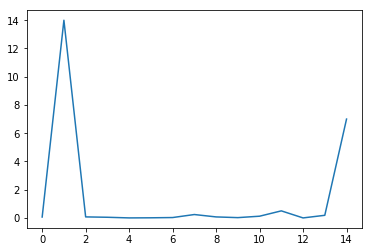

In [63]:
plt.plot(rankimean)

In [65]:
# top5 진입 일수
rankindays = np.fromiter(map(rankInDays, df['title'], ['genie']*len(df)), np.int32)
rankindays = np.array((rankimean + 1) / (chartindays+1))
rankindays

결과 데이터가 없습니다.
결과 데이터가 없습니다.


array([6.73420660e-04, 1.50000000e+01, 7.81987097e-04, 4.94456443e-04,
       7.64524212e-04, 4.65076770e-03, 2.77574872e-04, 3.01041568e-03,
       7.80924615e-04, 1.08646446e-02, 1.38545953e-03, 7.50000000e-01,
       7.05218268e-04, 2.26667008e-03, 8.00000000e+00])

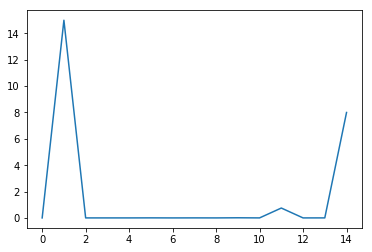

In [66]:
plt.plot(rankindays)

In [67]:
chartindays = np.array((chartindays+0.01) / (chartindays+1))
chartindays

array([0.99937302, 0.01      , 0.99927843, 0.99953236, 0.99924427,
       0.99543779, 0.99973243, 0.99759709, 0.99927843, 0.98946809,
       0.99877778, 0.505     , 0.99930233, 0.99810707, 0.01      ])

### 속성 합치기

In [68]:
data = np.array([chartindays, rankimean, rankindays]).T
data

array([[9.99373021e-01, 6.33312223e-02, 6.73420660e-04],
       [1.00000000e-02, 1.40000000e+01, 1.50000000e+01],
       [9.99278426e-01, 7.28862974e-02, 7.81987097e-04],
       [9.99532357e-01, 4.67642891e-02, 4.94456443e-04],
       [9.99244275e-01, 1.52671756e-03, 7.64524212e-04],
       [9.95437788e-01, 9.21658986e-03, 4.65076770e-03],
       [9.99732432e-01, 2.70270270e-02, 2.77574872e-04],
       [9.97597087e-01, 2.40291262e-01, 3.01041568e-03],
       [9.99278426e-01, 7.14285714e-02, 7.80924615e-04],
       [9.89468085e-01, 2.12765957e-02, 1.08646446e-02],
       [9.98777778e-01, 1.22222222e-01, 1.38545953e-03],
       [5.05000000e-01, 5.00000000e-01, 7.50000000e-01],
       [9.99302326e-01, 7.04721635e-04, 7.05218268e-04],
       [9.98107075e-01, 1.85468451e-01, 2.26667008e-03],
       [1.00000000e-02, 7.00000000e+00, 8.00000000e+00]])

In [69]:
# [chartindays, rankimean, rankindays]
x_data = data

# [기타, 포유류, 조류]
# 다음과 같은 형식을 one-hot 형식의 데이터라고 합니다.
y_data = labels

#########
# 신경망 모델 구성
######
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

# 신경망은 2차원으로 [입력층(특성), 출력층(레이블)] -> [2, 3] 으로 정합니다.
W = tf.Variable(tf.random_uniform([3, 1], -1., 1.))

# 편향을 각각 각 레이어의 아웃풋 갯수로 설정합니다.
# 편향은 아웃풋의 갯수, 즉 최종 결과값의 분류 갯수인 3으로 설정합니다.
b = tf.Variable(tf.zeros([1]))

# 신경망에 가중치 W과 편향 b을 적용합니다
L = tf.add(tf.matmul(X, W), b)
# 가중치와 편향을 이용해 계산한 결과 값에
# 텐서플로우에서 기본적으로 제공하는 활성화 함수인 ReLU 함수를 적용합니다.
L = tf.nn.sigmoid(L)

# 마지막으로 softmax 함수를 이용하여 출력값을 사용하기 쉽게 만듭니다
# softmax 함수는 다음처럼 결과값을 전체합이 1인 확률로 만들어주는 함수입니다.
# 예) [8.04, 2.76, -6.52] -> [0.53 0.24 0.23]
model = L

# 신경망을 최적화하기 위한 비용 함수를 작성합니다.
# 각 개별 결과에 대한 합을 구한 뒤 평균을 내는 방식을 사용합니다.
# 전체 합이 아닌, 개별 결과를 구한 뒤 평균을 내는 방식을 사용하기 위해 axis 옵션을 사용합니다.
# axis 옵션이 없으면 -1.09 처럼 총합인 스칼라값으로 출력됩니다.
#        Y         model         Y * tf.log(model)   reduce_sum(axis=1)
# 예) [[1 0 0]  [[0.1 0.7 0.2]  -> [[-1.0  0    0]  -> [-1.0, -0.09]
#     [0 1 0]]  [0.2 0.8 0.0]]     [ 0   -0.09 0]]
# 즉, 이것은 예측값과 실제값 사이의 확률 분포의 차이를 비용으로 계산한 것이며,
# 이것을 Cross-Entropy 라고 합니다.
cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(model), axis=1))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train_op = optimizer.minimize(cost)


#########
# 신경망 모델 학습
######
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(10):
    sess.run(train_op, feed_dict={X: x_data, Y: y_data})

    if (step + 1) % 10 == 0:
        print(step + 1, sess.run(cost, feed_dict={X: x_data, Y: y_data}))


#########
# 결과 확인
# 0: 기타 1: 포유류, 2: 조류
######/''''''''''''''''''''''''''''''''''''''''''''''''''''''
# tf.argmax: 예측값과 실제값의 행렬에서 tf.argmax 를 이용해 가장 큰 값을 가져옵니다.
# 예) [[0 1 0] [1 0 0]] -> [1 0]
#    [[0.2 0.7 0.1] [0.9 0.1 0.]] -> [1 0]
prediction = model
target = Y
print('예측값:', sess.run(prediction, feed_dict={X: x_data}))
print('실제값:', sess.run(target, feed_dict={Y: y_data}))

#is_correct = tf.equal(prediction, target)
#accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
#print('정확도: %.2f' % sess.run(accuracy * 100, feed_dict={X: x_data, Y: y_data}))

10 1.6689322e-07
예측값: [[0.28556192]
 [1.        ]
 [0.2870657 ]
 [0.2829685 ]
 [0.27624464]
 [0.27888253]
 [0.27989483]
 [0.3142324 ]
 [0.28684187]
 [0.2830736 ]
 [0.29491603]
 [0.64652616]
 [0.27609888]
 [0.30518767]
 [0.9999975 ]]
실제값: [[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [29]:
sess.run(target, feed_dict={Y:y_data})

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.]], dtype=float32)

In [30]:
sess.run(prediction, feed_dict={X: x_data})

array([[1.        ],
       [0.9879169 ],
       [1.        ],
       [1.        ],
       [0.55226916],
       [0.5524175 ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.55265015],
       [1.        ],
       [0.4878125 ],
       [0.46837515],
       [1.        ],
       [0.8857731 ]], dtype=float32)

In [31]:
from matplotlib import pyplot as plt

In [36]:
data

array([[9.99373021e-01, 9.90000063e+01, 9.90000127e+01],
       [1.00000000e-02, 1.30100000e+01, 1.30200000e+01],
       [9.99278426e-01, 9.90000073e+01, 9.90000146e+01],
       [9.99532357e-01, 9.80000047e+01, 9.80000094e+01],
       [9.99244275e-01, 1.00000763e+00, 1.00001527e+00],
       [9.95437788e-01, 1.00004608e+00, 1.00009217e+00],
       [9.99732432e-01, 9.90000027e+01, 9.90000054e+01],
       [9.97597087e-01, 9.80000243e+01, 9.80000485e+01],
       [9.99278426e-01, 9.70000073e+01, 9.70000146e+01],
       [9.89468085e-01, 1.00010638e+00, 1.00021277e+00],
       [9.98777778e-01, 9.80000123e+01, 9.80000247e+01],
       [5.05000000e-01, 5.00000000e-03, 1.00000000e-02],
       [9.99302326e-01, 7.04721635e-06, 1.40944327e-05],
       [9.98107075e-01, 9.60000191e+01, 9.60000382e+01],
       [1.00000000e-02, 6.01000000e+00, 6.02000000e+00]])

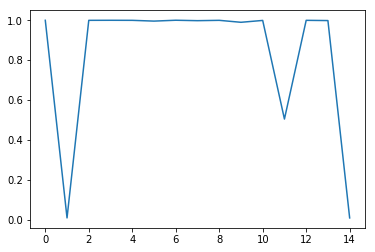

In [38]:
plt.plot(data.T[0])

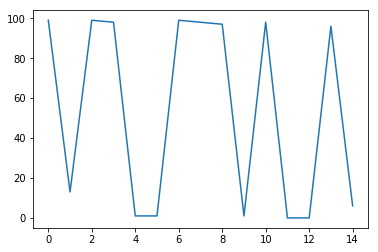

In [44]:
plt.plot(data.T[1])

In [41]:
data.T[0]

array([0.99937302, 0.01      , 0.99927843, 0.99953236, 0.99924427,
       0.99543779, 0.99973243, 0.99759709, 0.99927843, 0.98946809,
       0.99877778, 0.505     , 0.99930233, 0.99810707, 0.01      ])

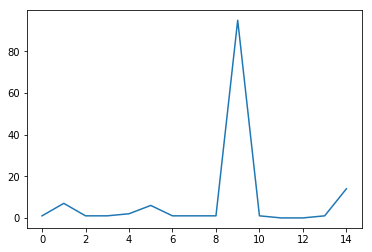

In [51]:
plt.plot(rankindays)